In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sys
from astropy import units as u 
import gc

from snewpy.neutrino import Flavor, MassHierarchy, MixingParameters
from snewpy.models.ccsn import Zha_2021, Nakazato_2013
from snewpy.flavor_transformation import AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence, \
                                         NeutrinoDecay, AdiabaticMSWes, NonAdiabaticMSWes

mpl.rc('font', size=18)
%matplotlib inline

In [2]:
model = Nakazato_2013(progenitor_mass=20*u.solMass, revival_time=100*u.ms, metallicity=0.004, eos='shen')
model.get_time()

<Quantity [-5.00e-02, -4.50e-02, -4.00e-02, -3.50e-02, -3.00e-02,
           -2.50e-02, -2.00e-02, -1.50e-02, -1.00e-02, -5.00e-03,
            0.00e+00,  1.00e-03,  2.00e-03,  3.00e-03,  4.00e-03,
            5.00e-03,  6.00e-03,  7.00e-03,  8.00e-03,  9.00e-03,
            1.00e-02,  1.10e-02,  1.20e-02,  1.30e-02,  1.40e-02,
            1.50e-02,  1.60e-02,  1.70e-02,  1.80e-02,  1.90e-02,
            2.00e-02,  2.10e-02,  2.20e-02,  2.30e-02,  2.40e-02,
            2.50e-02,  2.60e-02,  2.70e-02,  2.80e-02,  2.90e-02,
            3.00e-02,  3.10e-02,  3.20e-02,  3.30e-02,  3.40e-02,
            3.50e-02,  3.60e-02,  3.70e-02,  3.80e-02,  3.90e-02,
            4.00e-02,  4.10e-02,  4.20e-02,  4.30e-02,  4.40e-02,
            4.50e-02,  4.60e-02,  4.70e-02,  4.80e-02,  4.90e-02,
            5.00e-02,  5.05e-02,  5.10e-02,  5.15e-02,  5.20e-02,
            5.25e-02,  5.30e-02,  5.35e-02,  5.40e-02,  5.45e-02,
            5.50e-02,  5.55e-02,  5.60e-02,  5.65e-02,  5.70e-02,
          

In [3]:
def plot_total_flux(model, xform_nmo, xform_imo):
    """Plot initial and oscillated neutrino luminosities.
    
    Parameters
    ----------
    model : SupernovaModel
        An input model from a CCSN simulation.
    flav_xform : FlavorTransformation
        A FlavorTransformation subclass; used to create an instance.
    """
    
    energies = np.linspace(1,51,101) * u.MeV    
    d = (10*u.kpc).to('cm').value # distance to SN
        
    times= np.linspace(0,0.2,101)  << u.s
    burst_epoch = times <= 0.3*u.s# 
    
    
    
    
    ilum = {}
    olum_nmo = {}
    olum_nmo_tof = {}
    
    for flavor in Flavor:#(0123)
        ilum[flavor] = np.zeros(len(times))
        olum_nmo[flavor] = np.zeros(len(times))
        olum_nmo_tof[flavor] = np.zeros(len(times))

    # Compute the transformed and untransformed flux at each time.
    for i, t in enumerate(times):
        ospec_nmo = model.get_transformed_spectra(t, energies, xform_nmo)
        ospec_nmo_tof = model.get_tof_transformed_spectra(t, energies, xform_nmo)

        for flavor in Flavor:
            for j, E in enumerate(energies):
               
                ospec_nmo[flavor][j] /= (4.*np.pi*d**2)
                ospec_nmo_tof[flavor][0][j] /= (4.*np.pi*d**2)
        
        for flavor in Flavor:
        
            
            olum_nmo[flavor][i] = np.trapezoid(ospec_nmo[flavor].to('1/(erg*s)'), energies.to('erg')).value
            olum_nmo_tof[flavor][i] = np.trapezoid(ospec_nmo_tof[flavor].to('1/(erg*s)'), energies.to('erg')).value            
            
    # make the figures 
    fig, ax = plt.subplots(1,1, figsize=(10,10), tight_layout=True)
    
    smax = [0.]
    titles = ['Nakazato_2013_total_flux_0.6eV']
    
    for j, phase in enumerate([burst_epoch]):
        
        timeunits =  's'
        for i, flavor in enumerate(Flavor):
            if i == 0:
                smax[j] = np.maximum(smax[j], 1.1*np.max(olum_nmo[1][phase]))
                    
            ax.plot(times[phase].to(timeunits),
                    olum_nmo[flavor][phase], label=f"{flavor.to_tex()} ", lw=3,
                    color='C0' if flavor==0 else 'C1' if flavor==1 else 'C2' if flavor==2 else 'C3',
                    ls=':' )
            ax.plot(times[phase].to(timeunits),
                    olum_nmo_tof[flavor][phase], label=f"{flavor.to_tex()} (tof_Transformed)", lw=3,
                    color='C0' if flavor==0 else 'C1' if flavor==1 else 'C2' if flavor==2 else 'C3',
                    ls= '-')
            
            
        ax.set(xlim=(times[phase][0].to(timeunits).value, times[phase][-1].to(timeunits).value),ylim=(0, smax[j]))
            
            
        ax.set(ylabel=r'flux [ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
        ax.legend(loc='upper right', ncol=1, fontsize=18)
            
        ax.set(title=titles)
        
      
            
        ax.set(xlabel='time [{}]'.format(timeunits))
            
        ax.grid(ls=':')

      
    return fig


C:\Users\M_bum\AppData\Local\Temp\ipykernel_36900\4132828508.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  olum_nmo_tof[flavor][i] = np.trapezoid(ospec_nmo_tof[flavor].to('1/(erg*s)'), energies.to('erg')).value


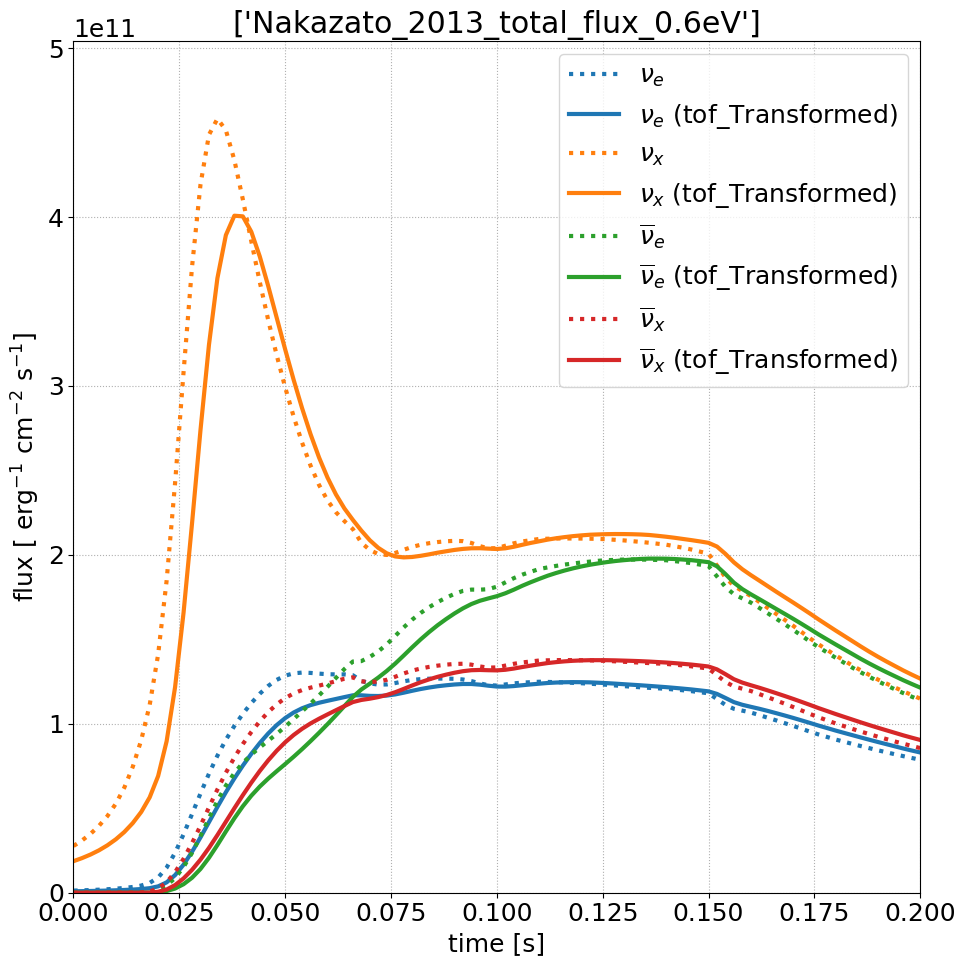

In [4]:
fig = plot_total_flux(model, AdiabaticMSW(), AdiabaticMSW(mh=MassHierarchy.INVERTED) )